# Siamese Recurrent Architectures - MALSTM
Siamese networks are networks that have two or more identical sub-networks in them. Siamese networks seem to perform well on similarity tasks and have been used for tasks like sentence semantic similarity, recognizing forged signatures and many more. 

In this notebook we evaluate MALSTM architecture proposed in [this paper](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023) in sentence similarity task using SICK and STS datasets. The paper uses Adadelta optimizer with word2vec. We evaluate how the performance varies with different optimizers and different word vectors. 

### Loading Data

#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [4]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [23]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]
sick_all.dtypes

idx        object
sent_1     object
sent_2     object
sim       float64
label      object
dtype: object

### Loading Embeddings
3 word embeddings were used for this experiment. Word2vec, Glove and fasttext.

#### Loading word2vec

In [6]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model.

In [7]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

#### Loading Fasttext
To load Fasttext, we used genism library

In [8]:
from embeddings.load_embeddings import load_fasttext
fasttext = load_fasttext("/data/fasttext/crawl-300d-2M-subword.vec")

#### Preparing Optimizers
Following optimizers were used to the neural network architecture.

In [9]:
from keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm=1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm)
sgd = SGD(clipnorm=gradient_clipping_norm)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm)
adagrad = Adagrad(clipnorm=gradient_clipping_norm)
adam = Adam(clipnorm=gradient_clipping_norm)
adamax = Adamax(clipnorm=gradient_clipping_norm)
nadam = Nadam(clipnorm=gradient_clipping_norm)

## MALSTM with Adadelta
We check the network with three word embeddings using adadelta optimizer.

1. MALSTM with Word2vec (As original Paper)
2. MALSTM with Glove
3. MALSTM with Fasttext

In [15]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=word2vec)),
             ("LSTM-GLOVE-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=glove)),
             ("LSTM-FASTTEXT-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


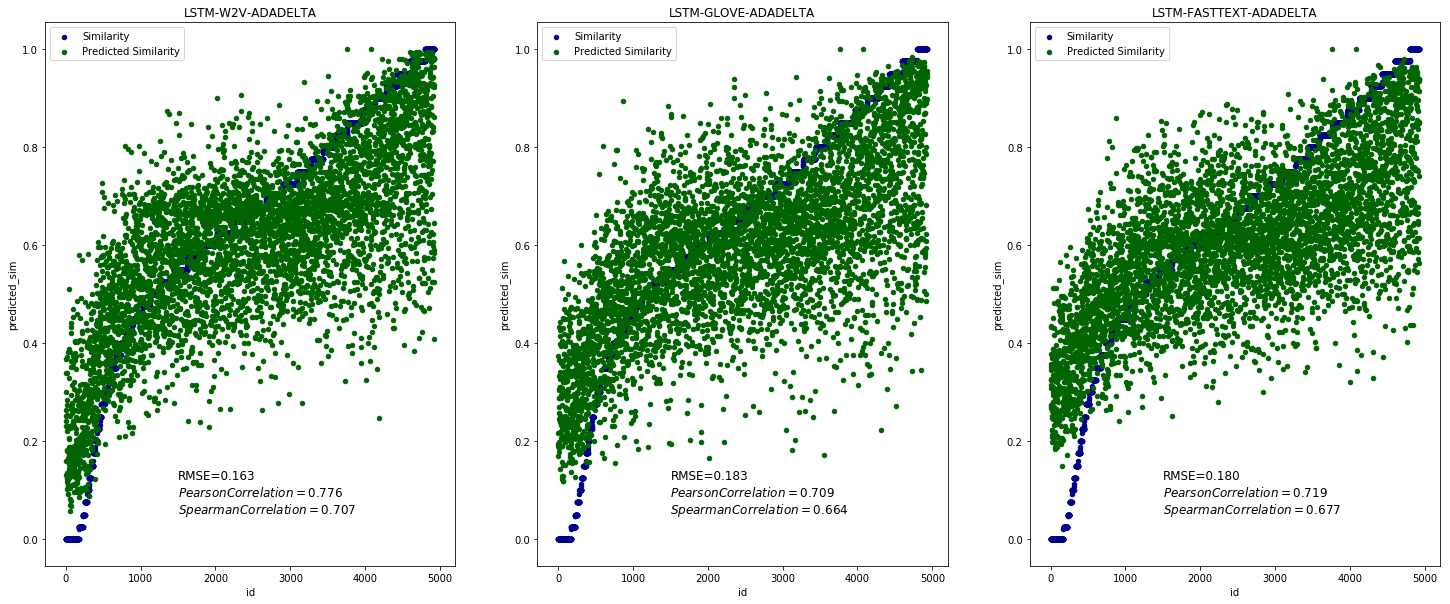

In [17]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with SGD
We check the network with three word embeddings using sgd optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [18]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-SGD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=word2vec)),
             ("LSTM-GLOVE-SGD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=glove)),
             ("LSTM-FASTTEXT-SGD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=sgd, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


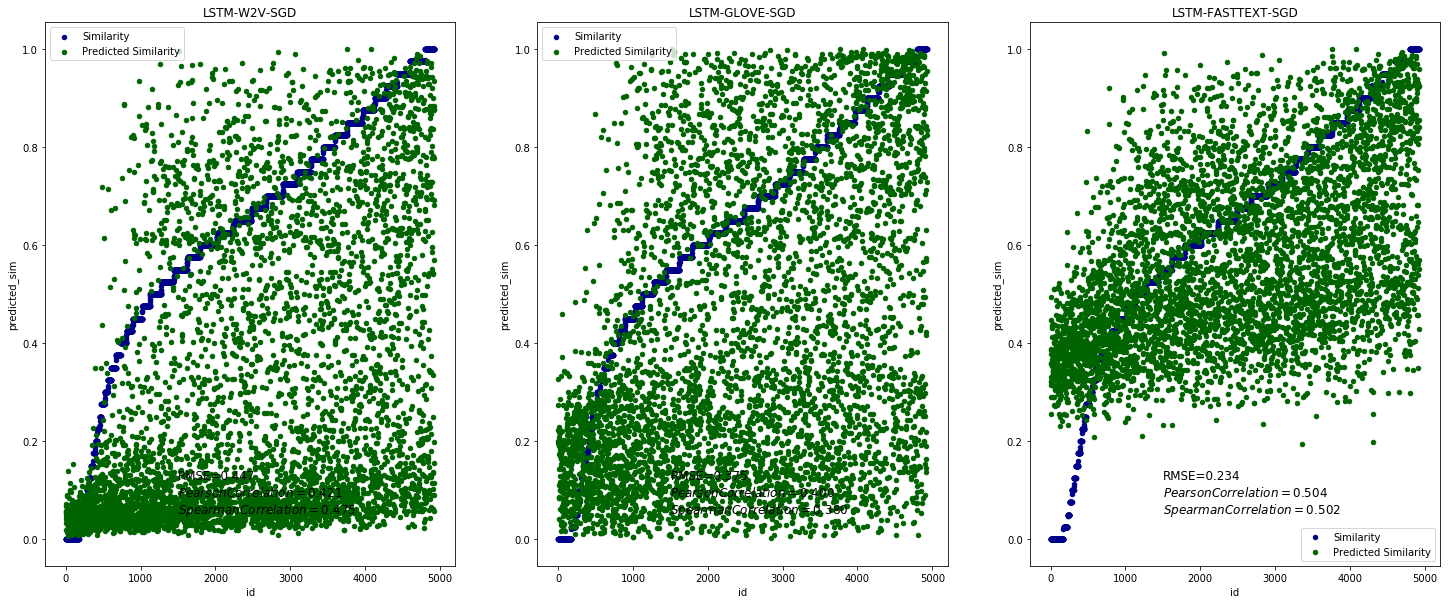

In [19]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with RMSPROP
We check the network with three word embeddings using rmsprop optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [21]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-RMSPROP", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=word2vec)),
             ("LSTM-GLOVE-RMSPROP", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=glove)),
             ("LSTM-FASTTEXT-RMSPROP", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=rmsprop, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


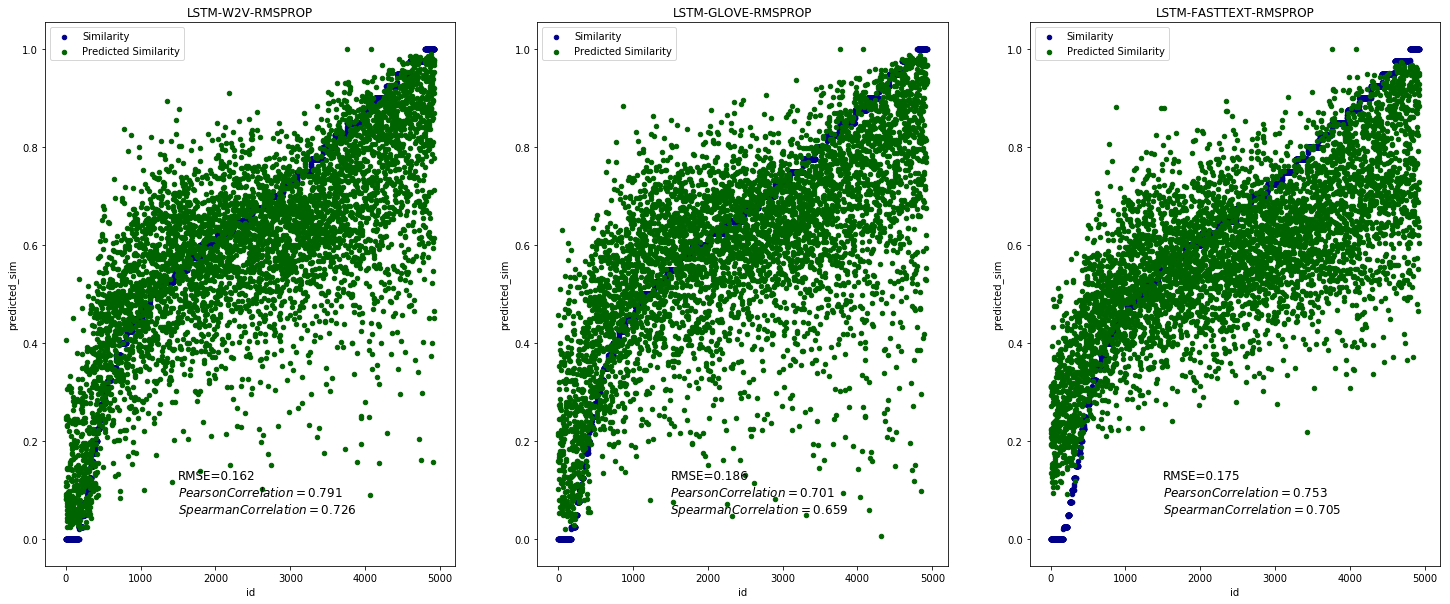

In [22]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with ADAGRAD
We check the network with three word embeddings using adagrad optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [25]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-ADAGRAD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=word2vec)),
             ("LSTM-GLOVE-ADAGRAD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=glove)),
             ("LSTM-FASTTEXT-ADAGRAD", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adagrad, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


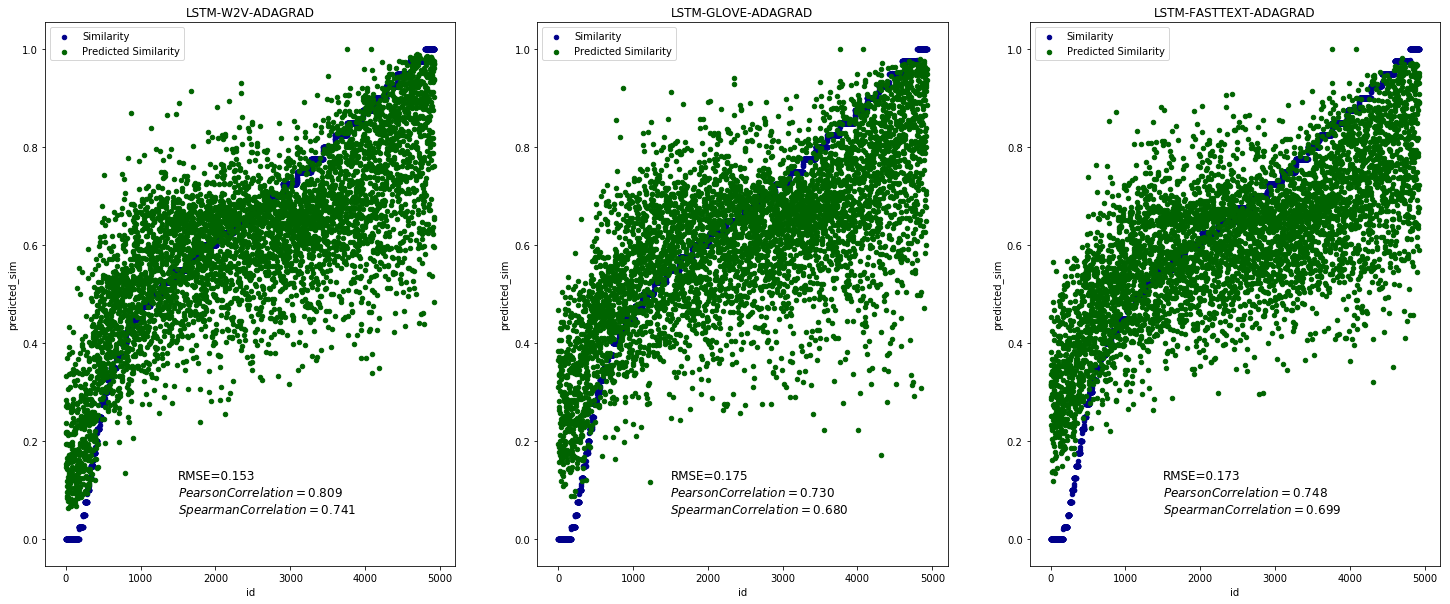

In [26]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with ADAM
We check the network with three word embeddings using adam optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [30]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-ADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=word2vec)),
             ("LSTM-GLOVE-ADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=glove)),
             ("LSTM-FASTTEXT-ADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adam, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


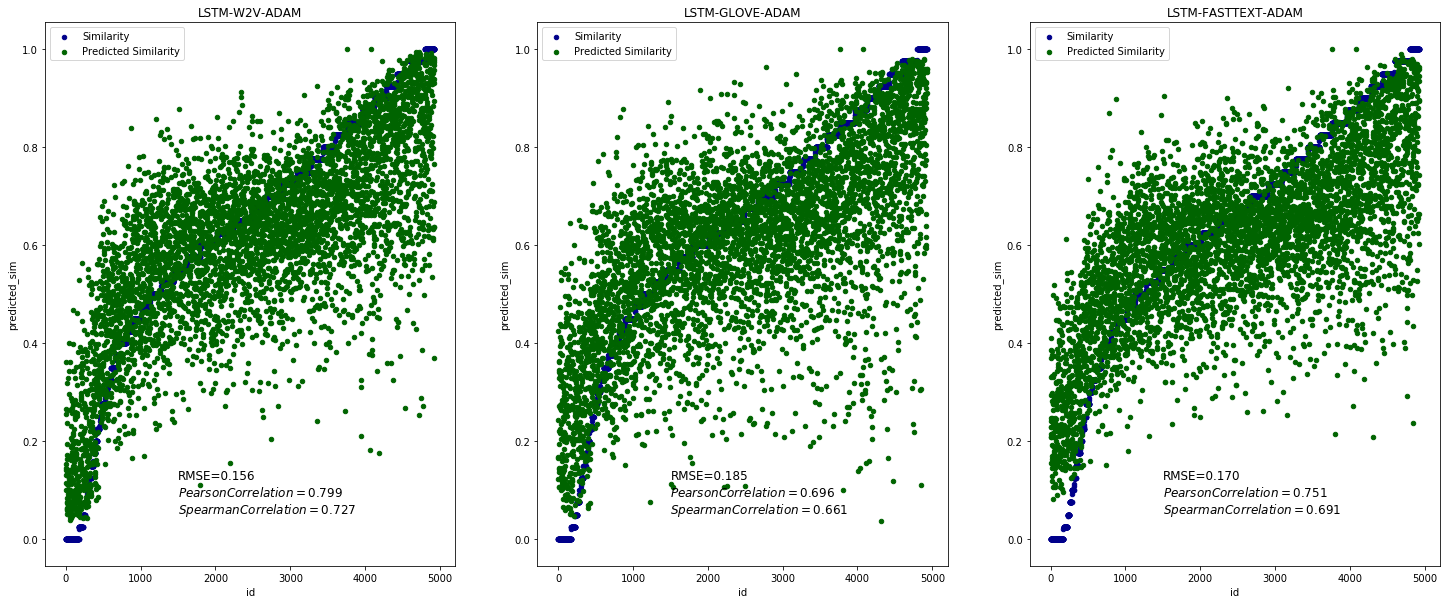

In [31]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with ADAMAX
We check the network with three word embeddings using adamax optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [33]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-ADAMAX", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=word2vec)),
             ("LSTM-GLOVE-ADAMAX", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=glove)),
             ("LSTM-FASTTEXT-ADAMAX", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adamax, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


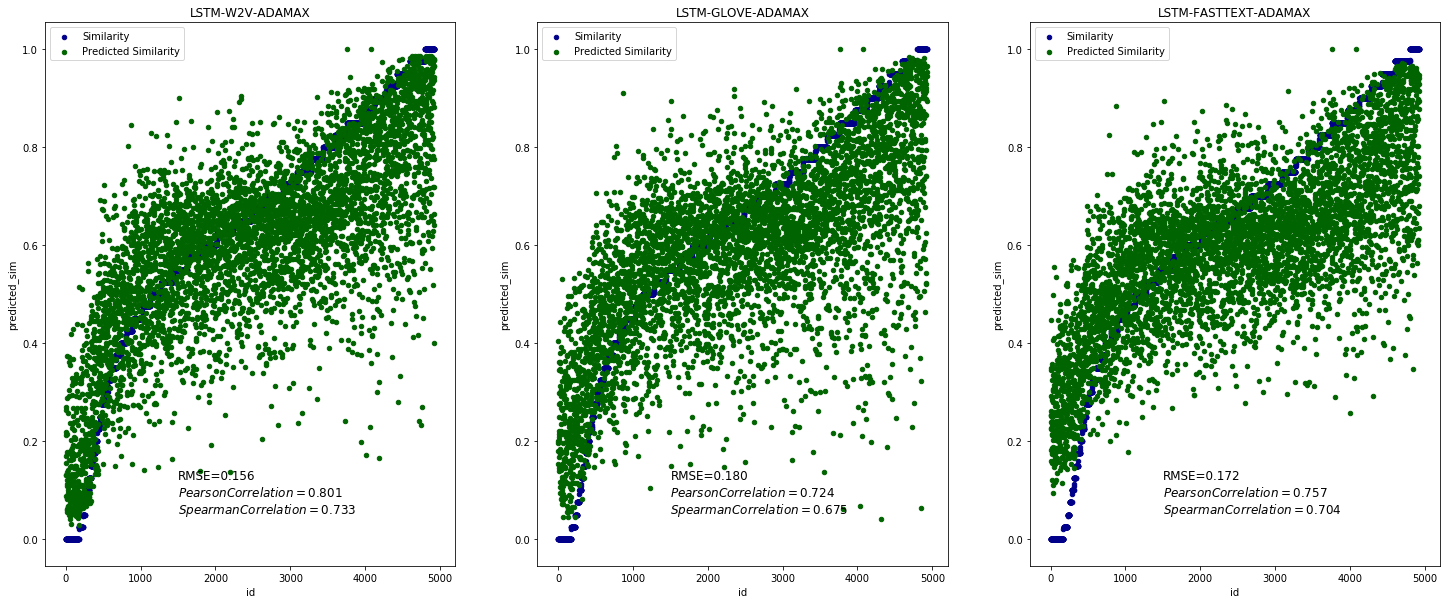

In [34]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## MALSTM with NADAM
We check the network with three word embeddings using nadam optimizer.

1. MALSTM with Word2vec
2. MALSTM with Glove
3. MALSTM with Fasttext

In [9]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=100

benchmarks = [("LSTM-W2V-NADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=word2vec)),
             ("LSTM-GLOVE-NADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=glove)),
             ("LSTM-FASTTEXT-NADAM", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=nadam, model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:79: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


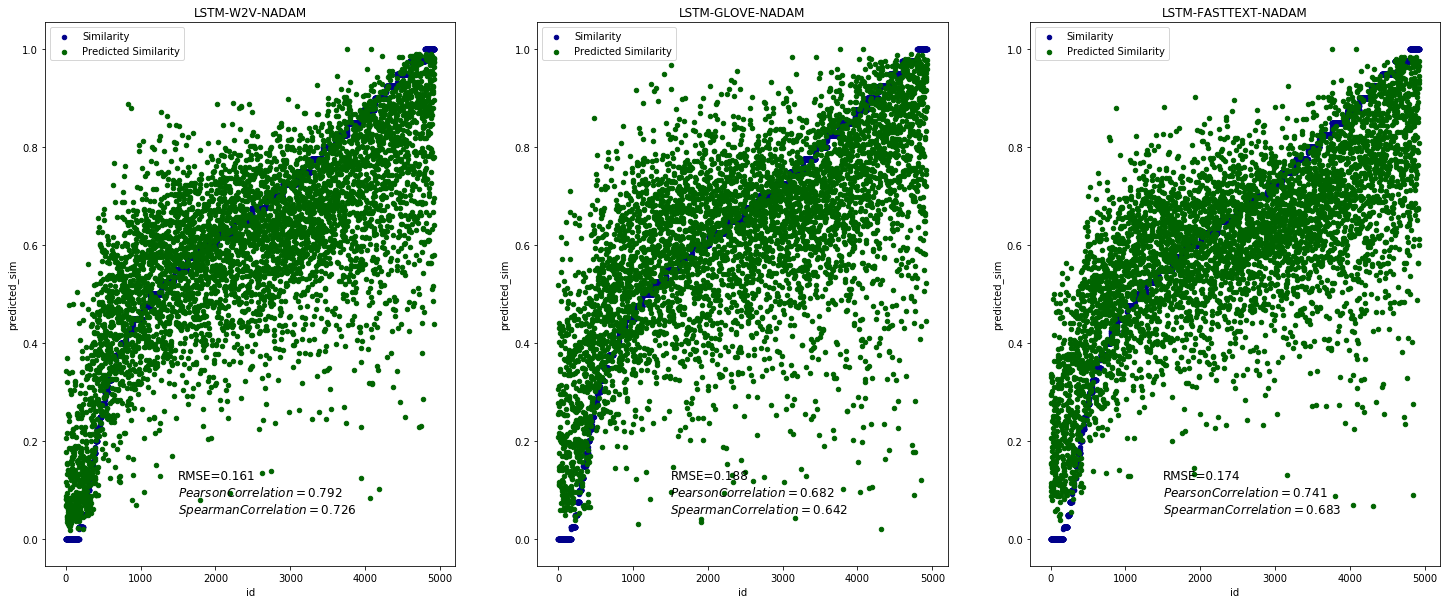

In [10]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
MALSTM worked genrally good with word2vec models other than glove and fasttext. We have to stick with the original paper's word embedding model.
However when several optimizers outperformed the optimizer used in the original paper - Adadelta. Adagrad gave the best performance improving the RMSE value by 0.013 than the original paper

## MALSTM - Transfer Learning

In [15]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=500

pre_benchmarks = [("LSTM-W2V-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/lstm_w2v_adadelta_weights.h5", load_weights=None, model=word2vec)),
             ("LSTM-GLOVE-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/lstm_glove_adadelta_weights.h5", load_weights=None, model=glove)),
             ("LSTM-FASTTEXT-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="moedls/lstm_fasttext_adadelta_weights.h5", load_weights=None, model=fasttext))]

benchmarks = [("LSTM-W2V-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_w2v_adadelta_weights.h5", model=word2vec)),
             ("LSTM-GLOVE-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_glove_adadelta_weights.h5", model=glove)),
             ("LSTM-FASTTEXT-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_fasttext_adadelta_weights.h5", model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


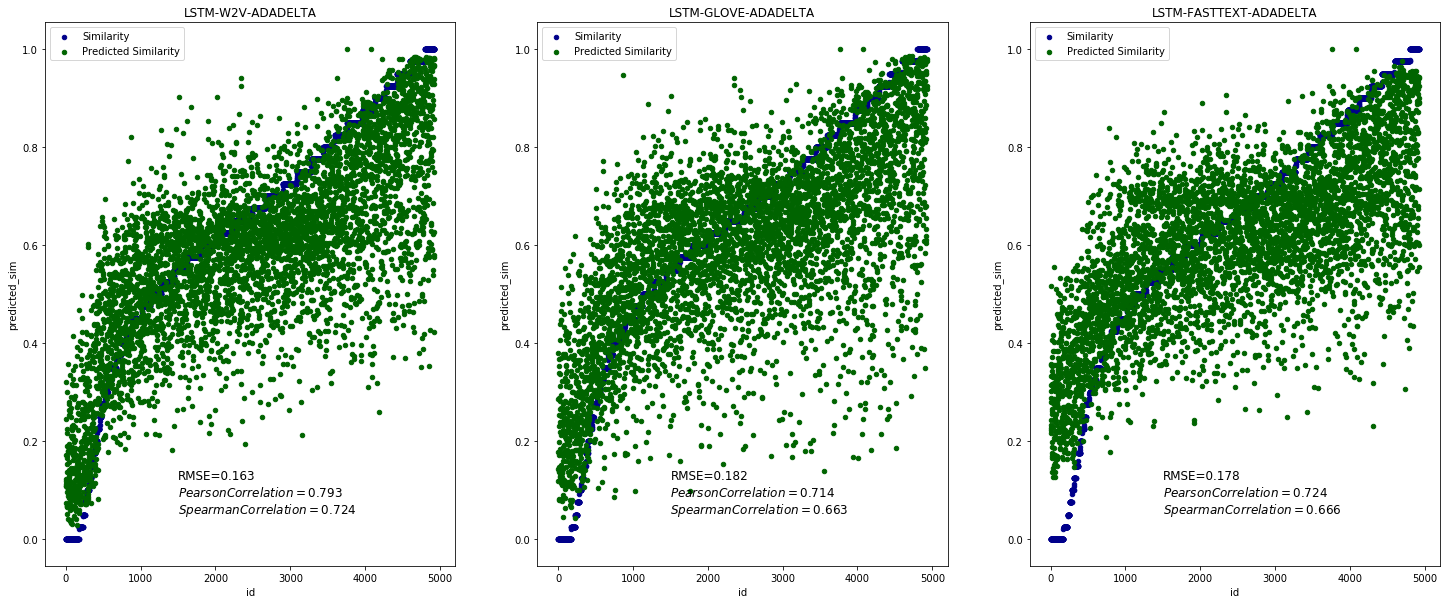

In [16]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sts_all = sts_dev.append(sts_test, ignore_index=True)
sts_all_normalized = normalize(sts_all, ["sim"])
sick_train_normlized = normalize(sick_train, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sts_sims, sts_trained_model, topic = run_experiment(sts_all_normalized, sts_all_normalized, ['sent_1', 'sent_2'], "sim", pre_benchmarks[i])
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
As in the original paper MALSTM was improved when using tranfer learning. The model was first trained using STS dataset and loaded the weights when training for SICK Dataset.

## MALSTM with thesaurus-based augmentation and transfer learning

In [28]:
import pandas as pd

sick_aug = pd.read_csv("data/sick_aug.csv", header=0)
sick_aug[:10]

,sent_1,sent_2,sim,label,rand_id
0,A man is typing on a machine used for stenography,There is no person riding a bike along a muddy...,1.0,NEUTRAL,9974.0
1,Two men are leaving the stage,Mimes are performing on a stage,3.1,NEUTRAL,1552.0
2,A man is wearing a purple shirt and black leat...,A model is wearing a purple shirt and black le...,4.4,ENTAILMENT,9393.0
3,A man is playing a keyboard in a park,A person is playing the keyboard,4.3,ENTAILMENT,1373.0
4,A cat is playing with a small bottle,A bottle is being licked by the cat,3.5,NEUTRAL,5664.0
5,A poor man is being fed snakes and mice,A snake is being fed a mouse by a man,2.3,NEUTRAL,1609.0
6,Two white dogs and one brown dog are chasing a...,Two white dogs and one brown dog are chasing a...,4.5,ENTAILMENT,7887.0
7,A group of mothers in uniforms is standing nea...,A group of children in uniforms is standing at...,3.3,NEUTRAL,315.0
8,Two men are riding an orange raft on the shore,Two men are getting off of an orange raft on t...,4.2,NEUTRAL,6460.0
9,There is no woman tapping her fingers,A woman is tapping her fingers on a table,3.8,CONTRADICTION,2233.0


In [35]:
import functools as ft
from nn.lstm import run_lstm_benchmark

validation_portion=0.1
n_hidden=100
embedding_dim=300
batch_size=64
n_epoch=500

pre_benchmarks = [("LSTM-W2V-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/lstm_w2v_adadelta_weights.h5", load_weights=None, model=word2vec)),
             ("LSTM-GLOVE-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/lstm_glove_adadelta_weights.h5", load_weights=None, model=glove)),
             ("LSTM-FASTTEXT-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights="models/lstm_fasttext_adadelta_weights.h5", load_weights=None, model=fasttext))]

benchmarks = [("LSTM-W2V-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_w2v_adadelta_weights.h5", model=word2vec)),
             ("LSTM-GLOVE-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_glove_adadelta_weights.h5", model=glove)),
             ("LSTM-FASTTEXT-ADADELTA", ft.partial(run_lstm_benchmark, validation_portion=validation_portion, n_hidden=n_hidden, embedding_dim=embedding_dim, batch_size=batch_size, n_epoch=n_epoch, optimizer=adadelta, save_weights=None, load_weights="models/lstm_fasttext_adadelta_weights.h5", model=fasttext))]

/home/tharindu/Projects/Siamese-Recurrent-Architectures/preprocessing/embeddings.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  dataset.set_value(index, question, q2n)
/home/tharindu/Projects/Siamese-Recurrent-Architectures/nn/lstm.py:78: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=([X_validation['left'], X_validation['right']], Y_validation))


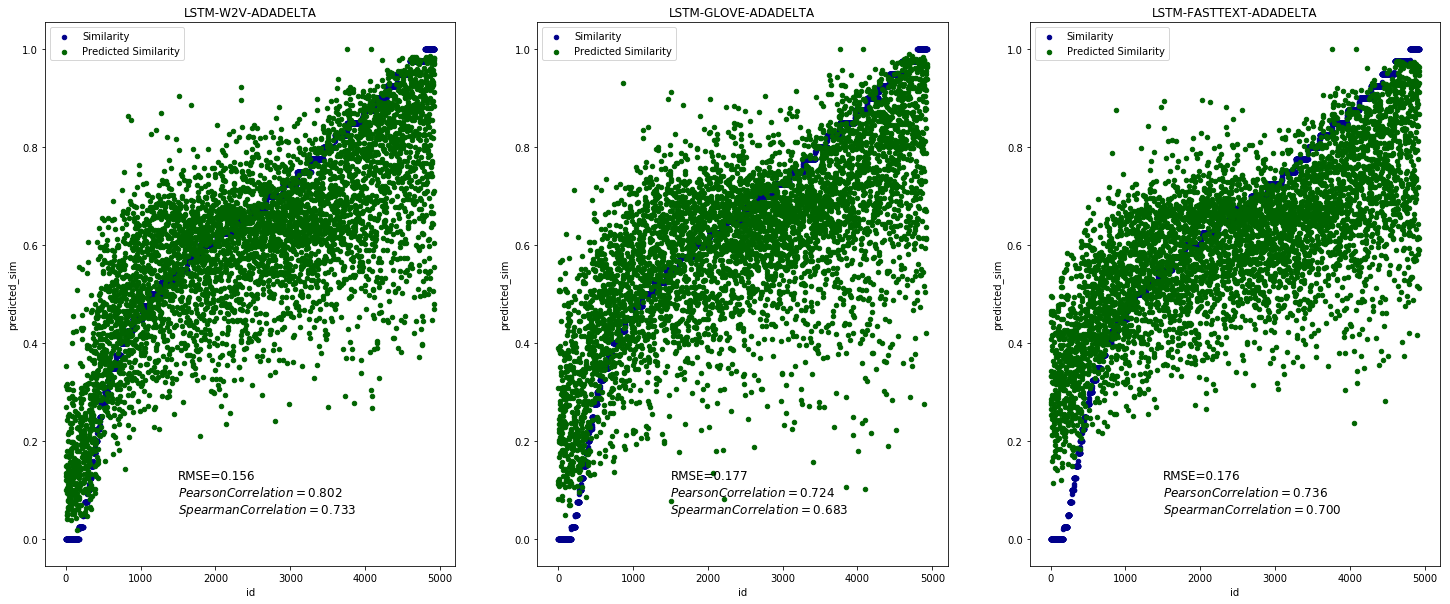

In [36]:
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
row = 0
column = 0
sts_all = sts_dev.append(sts_test, ignore_index=True)
sts_all_normalized = normalize(sts_all, ["sim"])
sick_train_normlized = normalize(sick_aug, ["sim"])
sick_test_normalized = normalize(sick_test, ["sim"])
for i in range(0, 3):
    sts_sims, sts_trained_model, topic = run_experiment(sts_all_normalized, sts_all_normalized, ['sent_1', 'sent_2'], "sim", pre_benchmarks[i])
    sims, trained_model, topic = run_experiment(sick_train_normlized, sick_test_normalized, ['sent_1', 'sent_2'], "sim", benchmarks[i])
    sick_test_normalized['predicted_sim'] = pd.Series(sims).values
    pearson_correlation = scipy.stats.pearsonr(sims, sick_test_normalized['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_test_normalized['sim'])[0]
    rmse = sqrt(mean_squared_error(sick_test_normalized['predicted_sim'], sick_test_normalized['sim']))
    textstr = 'RMSE=%.3f\n$Pearson Correlation=%.3f$\n$Spearman Correlation=%.3f$'%(rmse, pearson_correlation, spearman_correlation)    
    sick_test_sorted = sick_test_normalized.sort_values('sim')
    id = list(range(0, len(sick_test_normalized.index)))
    sick_test_sorted['id'] = pd.Series(id).values
    
    if(i < 3):
        row=0
        column = i
        
    sick_test_sorted.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_test_sorted.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

## Conclusions
As in the original paper MALSTM was improved when using tranfer learning and thesaurus-based augmentation for the training set.